In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import itertools
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [3]:
# parameters
settings = ['LAN', 'WAN']
#settings = ['LAN']
parties = [0,1]
protocols = ['scs', 'poly']

all_params = itertools.product(settings, parties, protocols)

data_filenames=['p0_lan.out', 'p0_wan.out', 'p1_lan.out', 'p1_wan.out']
#data_filenames=['p0_lan.out', 'p1_lan.out']
raw_data = {}
pir_type = ""
k_A, k_B, l, n, time_reduction, time_total = 0., 0., 0., 0., 0., 0.
for i_setting, setting in enumerate(settings):
    for p in parties:
        with open(data_filenames[p*len(settings) + i_setting]) as f:
            for line in f.read().splitlines():
                fields = line.split()
                if fields[0] == "Running":
                    pir_type = fields[-1][1:-1]
                    if (setting, p, pir_type) not in raw_data:
                        raw_data[(setting, p, pir_type)] = []
                if fields[0] == "l":
                    l = fields[-1]
                if fields[0] == "n":
                    n = fields[-1]
                if fields[0] == "k_A":
                    k_A = fields[-1]
                if fields[0] == "k_B":
                    k_B = fields[-1]
                if fields[0] == "mpc_time:":
                    time_reduction = fields[-2]
                if fields[0] == "Sparse":
                    time_total = fields[-2]
                    if(int(k_A) >= int(k_B)):
                        raw_data[(setting, p, pir_type)] += \
                            [[k_A, k_B, l, n, time_reduction, time_total]]

data = {param : np.array(raw_data[param], dtype=np.float64) for param in raw_data.keys()}

# data is (k_A, k_B, l, n)
f_dense = lambda data,a,b,c: \
    [a * m * data[:,2] * data[:,3] + \
    b * m * data[:,2] + \
    c * m * data[:,3] for m in [data[:,0] + data[:,1]]][0]
fs = {
    'reduction': {
        'scs': lambda data,a,b,c,: [a*m + b*m*np.log2(m) + c 
            for m in [data[:,0] + data[:,1]]][0],
        'poly': lambda data,a,b,c,d: a * data[:,0] * data[:,1] + \
            b * data[:,0] + c * data[:,1] + d,
    },
    'total': { # same for both parties
        'scs': lambda data,a,b,c,d,e,f: fs['reduction']['scs'](data,a,b,c) + \
            f_dense(data,d,e,f),
        'poly': lambda data,a,b,c,d,e,f,g: fs['reduction']['poly'](data,a,b,c,d) + \
            f_dense(data,e,f,g)
    }
}
f_index = {'reduction': 4, 'total': 5}

coeffs = {
    params : {k: curve_fit(fs[k][params[2]], data[params][:,:4], data[params][:,f_index[k]])[0]
              for k in fs.keys()}
    for params in data.keys()
}

def model(params, phase):
    (setting, p, algo) = params
    return lambda data: fs[phase][algo](data, *(coeffs[params][phase]))

/usr/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


k-NN (LAN)
Languages, ngrams=5 {'reduction': [{'scs': 5.481745261831275, 'poly': 0.6407213880773551}, {'scs': 5.407991238724918, 'poly': 0.5864365415700068}, {'scs': 0.9717949099580065, 'poly': 0.3977835363995512}, {'scs': 127.34213031849104, 'poly': 31.604712731377866}], 'total': [{'scs': 14.040839608525857, 'poly': 10.390819996595383}, {'scs': 13.057586292736232, 'poly': 9.317478254437447}, {'scs': 1.0823606148187537, 'poly': 0.4962030742317438}, {'scs': 138.73304564133286, 'poly': 46.86994290351868}]}


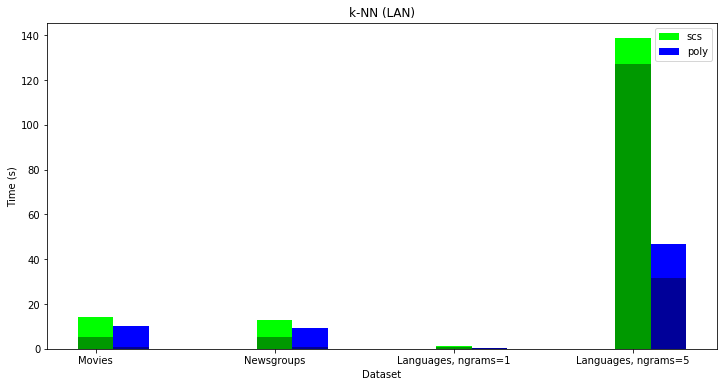


k-NN (WAN)
Languages, ngrams=5 {'reduction': [{'scs': 15.77033585717684, 'poly': 5.239242306178221}, {'scs': 15.630772213637632, 'poly': 5.121615705020448}, {'scs': 7.053164973940752, 'poly': 4.693783082943791}, {'scs': 237.2238380388264, 'poly': 74.0845878883826}], 'total': [{'scs': 33.355541052878834, 'poly': 18.243690067902207}, {'scs': 31.35413849289762, 'poly': 16.776559250429273}, {'scs': 7.2773042303015245, 'poly': 4.957048273645341}, {'scs': 260.2308996543288, 'poly': 92.70702955126762}]}


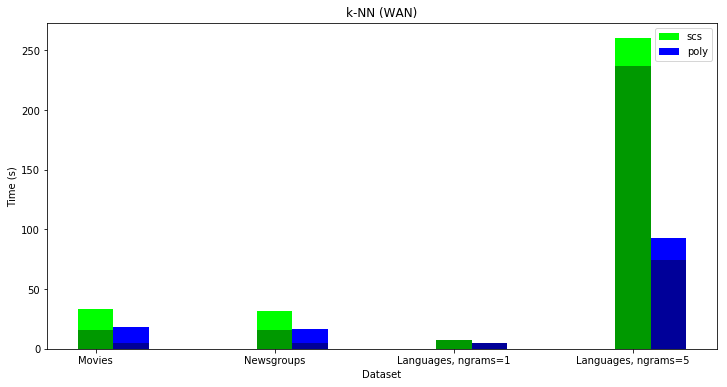

In [5]:
algos = ['scs', 'poly']
phase = 'local + mpc'
party = 0
def knn(setting, phase, l, m, s_1, s_64):
    num_batches = l / 64.
    return {algo: model((setting, party, algo), phase)(np.array([[m * s_64, m * s_1, l, 1]]))[0] for algo in algos}

#(l, m, s_1, s_64)
datasets = {
    'Movies': (10000, 124247, 0.001, 0.028),
    'Newsgroups': (9051, 101631, 0.001, 0.034),
    'Languages, ngrams=1': (783, 1017, 0.023, 0.374),
    'Languages, ngrams=5': (783, 272796, 0.052, 0.1704),
}

bar_width = 0.2
algo_colors = [[0.,1.,0.],[0.,0.,1.]]
phase_brightness = [0.6, 1]
for setting in ['LAN', 'WAN']:
    print("k-NN ({})".format(setting))
    timings = {k : [] for k in fs.keys()}
    for k in datasets.keys():
        for phase in fs.keys():
            timings[phase] += [knn(setting, phase, *datasets[k])]
    print(k, timings)
    rects = []
    for (i, algo) in enumerate(algos):
        bottom = np.array([0.] * len(datasets))
        for (j, phase) in enumerate(timings.keys()):
            rect = plt.bar(np.arange(len(datasets)) + i * bar_width, 
                [t[algo] for t in timings[phase]] - bottom, bar_width,
                bottom = bottom,
                color = np.array(algo_colors[i]) * phase_brightness[j])
            if j == 1:
                rects += [rect]
            bottom += [t[algo] for t in timings[phase]]
    plt.legend(rects, algos)
    plt.xticks(range(len(datasets)), datasets.keys())
    plt.xlabel('Dataset')
    plt.ylabel('Time (s)')
    #plt.yscale('log')
    plt.title("k-NN ({})".format(setting))
    plt.savefig('knn_{}.pdf'.format(setting), bbox_inches='tight')
    plt.show()
    print()
    